# Comparison of Pre-trained Models for Cat and Dog Classification

## 1. Setup and Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    EfficientNetB0, ResNet50, VGG16,
    efficientnet, resnet, vgg16
)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import requests
from PIL import Image
from io import BytesIO

In [2]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
TRAIN_DIR = './dataset_dogs_vs_cats/train'
TEST_DIR = './dataset_dogs_vs_cats/test'
MODEL_SAVE_DIR = './saved_models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

## 2. Data Loading and Preprocessing

In [3]:
# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 6401 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1999 images belonging to 2 classes.


## 3. Model Creation and Training

### 3.1. EfficientNetB0

In [12]:
%pip install numpy pandas matplotlib scikit-learn scipy

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.7 MB 2.9 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.7 MB 3.2 MB/s eta 0:00:03
   -------- ------------------------------- 1.8/8.7 MB 3.2 MB/s eta 0:00:03
   ------------- -------------------------- 2.9/8.7 MB 3.4 MB/s eta 0:00:02
   ---------------- ----------------------- 3.7/8.7 MB 3.6 MB/s eta 0:00:02
   -------------------- ------------------- 4.5/8.7 MB 3.7 MB/s eta 0:00:02
   ------------------------- -------------- 5.5/8.7 MB 3.8 MB/s eta 0:00:01
   ------------------------------ --------- 6.6/8.7 MB 3.9 MB/s eta 0:00:01
   ---------------------------------- ----- 7.6/8.7 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 4.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   - -------------------------------------- 1.0/38.5 MB 5.3 MB/s eta 0:00:08
   -- ------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
# Check the shape of the data from the generator
sample_batch = next(train_generator)
print(f"Input shape: {sample_batch[0].shape}")  # Should be (batch_size, 224, 224, 3) for RGB
print(f"Number of channels in first image: {sample_batch[0][0].shape[-1]}")

Input shape: (32, 224, 224, 3)
Number of channels in first image: 3


In [20]:
# For EfficientNetB0
base_effnet = EfficientNetB0(
    weights=None,  # Can't use ImageNet weights with different input channels
    include_top=False,
    input_shape=(224, 224, 3)  # Single channel input
)

# Freeze the base model
base_effnet.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = efficientnet.preprocess_input(inputs)
x = base_effnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

effnet_model = Model(inputs, outputs)

# Compile the model
effnet_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
effnet_history = effnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint(
            os.path.join(MODEL_SAVE_DIR, 'efficientnet_best.h5'),
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
    ]
)

Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.4890 - loss: 0.6933

c:\Users\ed\Documents\maestria\jupyter\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.4876 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.5046 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.4995 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.4973 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932


### 3.2. ResNet50

In [21]:
# Create ResNet50 model
base_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_resnet.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = resnet.preprocess_input(inputs)
x = base_resnet(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs, outputs)

# Compile the model
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
resnet_history = resnet_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint(
            os.path.join(MODEL_SAVE_DIR, 'resnet50_best.h5'),
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
    ]
)

Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5179 - loss: 0.7504

201/201 ━━━━━━━━━━━━━━━━━━━━ 579s 3s/step - accuracy: 0.5190 - loss: 0.7160 - val_accuracy: 0.5088 - val_loss: 0.6915
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5426 - loss: 0.6897

201/201 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - accuracy: 0.5438 - loss: 0.6871 - val_accuracy: 0.5763 - val_loss: 0.6805
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 601s 3s/step - accuracy: 0.5379 - loss: 0.6889 - val_accuracy: 0.5088 - val_loss: 0.6840
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 642s 3s/step - accuracy: 0.5527 - loss: 0.6842 - val_accuracy: 0.5725 - val_loss: 0.6772
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5563 - loss: 0.6821

201/201 ━━━━━━━━━━━━━━━━━━━━ 749s 4s/step - accuracy: 0.5576 - loss: 0.6818 - val_accuracy: 0.5788 - val_loss: 0.6778
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5526 - loss: 0.6836

201/201 ━━━━━━━━━━━━━━━━━━━━ 666s 3s/step - accuracy: 0.5527 - loss: 0.6827 - val_accuracy: 0.6144 - val_loss: 0.6712
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 0.5648 - loss: 0.6796 - val_accuracy: 0.6019 - val_loss: 0.6711
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 0.5685 - loss: 0.6782 - val_accuracy: 0.6044 - val_loss: 0.6700
Epoch 9/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 570s 3s/step - accuracy: 0.5641 - loss: 0.6783 - val_accuracy: 0.5663 - val_loss: 0.6734
Epoch 10/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 572s 3s/step - accuracy: 0.5802 - loss: 0.6772 - val_accuracy: 0.5556 - val_loss: 0.6800


### 3.3. VGG16

In [22]:
# Create VGG16 model
base_vgg = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_vgg.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = vgg16.preprocess_input(inputs)
x = base_vgg(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

vgg_model = Model(inputs, outputs)

# Compile the model
vgg_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
vgg_history = vgg_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ModelCheckpoint(
            os.path.join(MODEL_SAVE_DIR, 'vgg16_best.h5'),
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
    ]
)

Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5020 - loss: 0.8286

201/201 ━━━━━━━━━━━━━━━━━━━━ 1586s 8s/step - accuracy: 0.5059 - loss: 0.7630 - val_accuracy: 0.5000 - val_loss: 0.7004
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5005 - loss: 0.7012

201/201 ━━━━━━━━━━━━━━━━━━━━ 1578s 8s/step - accuracy: 0.4980 - loss: 0.7001 - val_accuracy: 0.5025 - val_loss: 0.6916
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 1581s 8s/step - accuracy: 0.5098 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6917
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 1535s 8s/step - accuracy: 0.5116 - loss: 0.6933 - val_accuracy: 0.4994 - val_loss: 0.6910
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5134 - loss: 0.6922

201/201 ━━━━━━━━━━━━━━━━━━━━ 1534s 8s/step - accuracy: 0.5182 - loss: 0.6923 - val_accuracy: 0.5031 - val_loss: 0.6910
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 1533s 8s/step - accuracy: 0.5132 - loss: 0.6923 - val_accuracy: 0.5025 - val_loss: 0.6923
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5200 - loss: 0.6924

201/201 ━━━━━━━━━━━━━━━━━━━━ 1532s 8s/step - accuracy: 0.5141 - loss: 0.6927 - val_accuracy: 0.5281 - val_loss: 0.6923
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 1530s 8s/step - accuracy: 0.5170 - loss: 0.6926 - val_accuracy: 0.5044 - val_loss: 0.6925


## 4. Model Evaluation

In [23]:
# Evaluate models on test set
effnet_test_loss, effnet_test_acc = effnet_model.evaluate(test_generator)
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_generator)
vgg_test_loss, vgg_test_acc = vgg_model.evaluate(test_generator)

print(f"EfficientNetB0 Test Accuracy: {effnet_test_acc:.4f}")
print(f"ResNet50 Test Accuracy: {resnet_test_acc:.4f}")
print(f"VGG16 Test Accuracy: {vgg_test_acc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 689ms/step - accuracy: 0.4997 - loss: 0.6931
63/63 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.6278 - loss: 0.6630
63/63 ━━━━━━━━━━━━━━━━━━━━ 379s 6s/step - accuracy: 0.5018 - loss: 0.6912
EfficientNetB0 Test Accuracy: 0.4997
ResNet50 Test Accuracy: 0.6278
VGG16 Test Accuracy: 0.5018


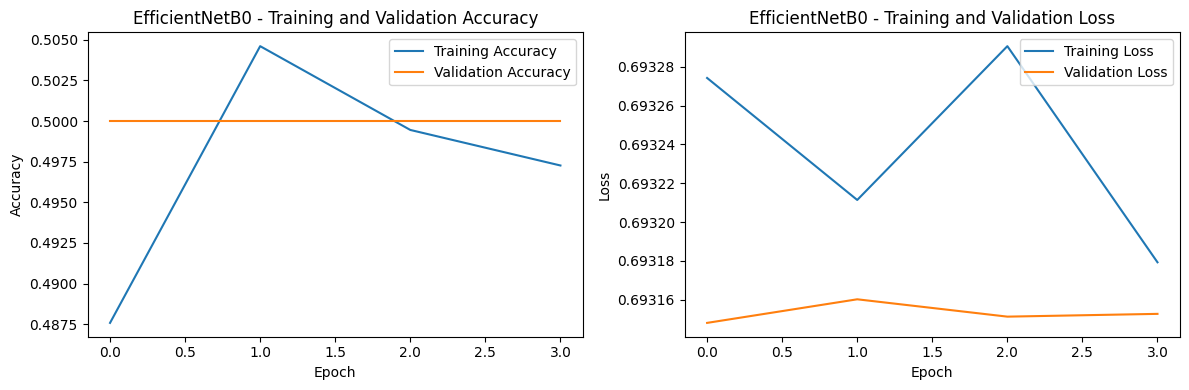

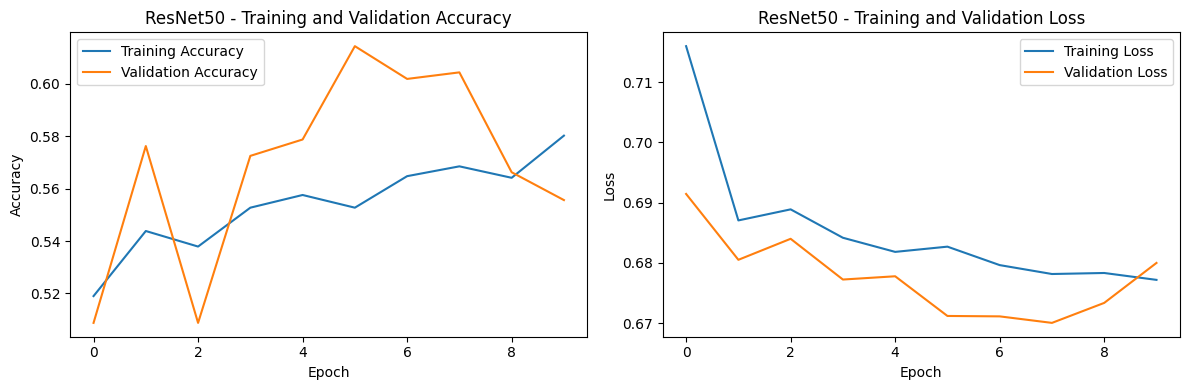

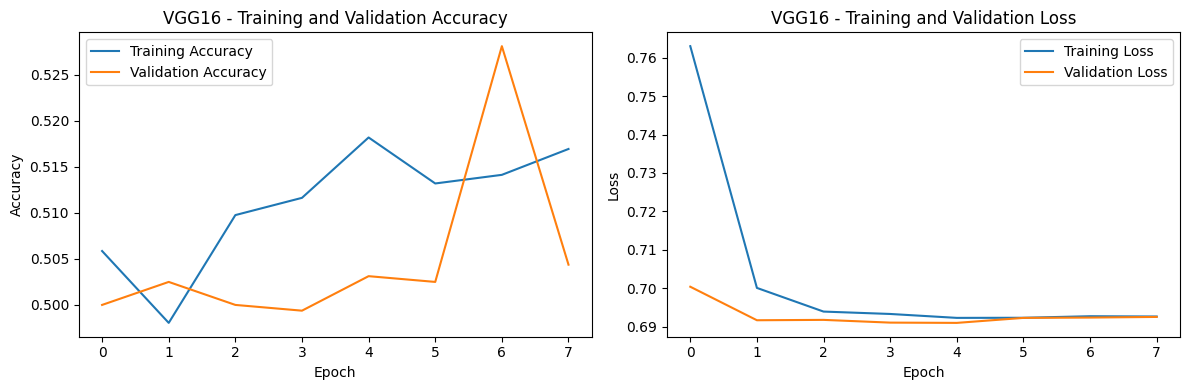

In [24]:
# Plot training history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(effnet_history, 'EfficientNetB0')
plot_history(resnet_history, 'ResNet50')
plot_history(vgg_history, 'VGG16')

## 5. Testing with Downloaded Images

In [25]:
def test_with_downloaded_images(model, class_indices):
    # Example image URLs
    test_images = {
        'cat1': 'https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_1280.jpg',
        'cat2': 'https://cdn.pixabay.com/photo/2014/11/30/14/11/cat-551554_1280.jpg',
        'dog1': 'https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_1280.jpg',
        'dog2': 'https://cdn.pixabay.com/photo/2018/01/09/11/04/dog-3071334_1280.jpg',
    }
    
    plt.figure(figsize=(15, 10))
    
    for i, (name, url) in enumerate(test_images.items(), 1):
        try:
            # Download and preprocess image
            response = requests.get(url)
            img = Image.open(BytesIO(response.content)).resize(IMG_SIZE)
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Make prediction
            prediction = model.predict(img_array)[0][0]
            predicted_class = 'dog' if prediction > 0.5 else 'cat'
            confidence = prediction if predicted_class == 'dog' else (1 - prediction)
            
            # Plot image with prediction
            plt.subplot(2, 2, i)
            plt.imshow(img)
            plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}')
            plt.axis('off')
            
        except Exception as e:
            print(f"Error processing {url}: {e}")
    
    plt.tight_layout()
    plt.show()


Best model: ResNet50 with test accuracy: 0.6278

Testing with downloaded images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


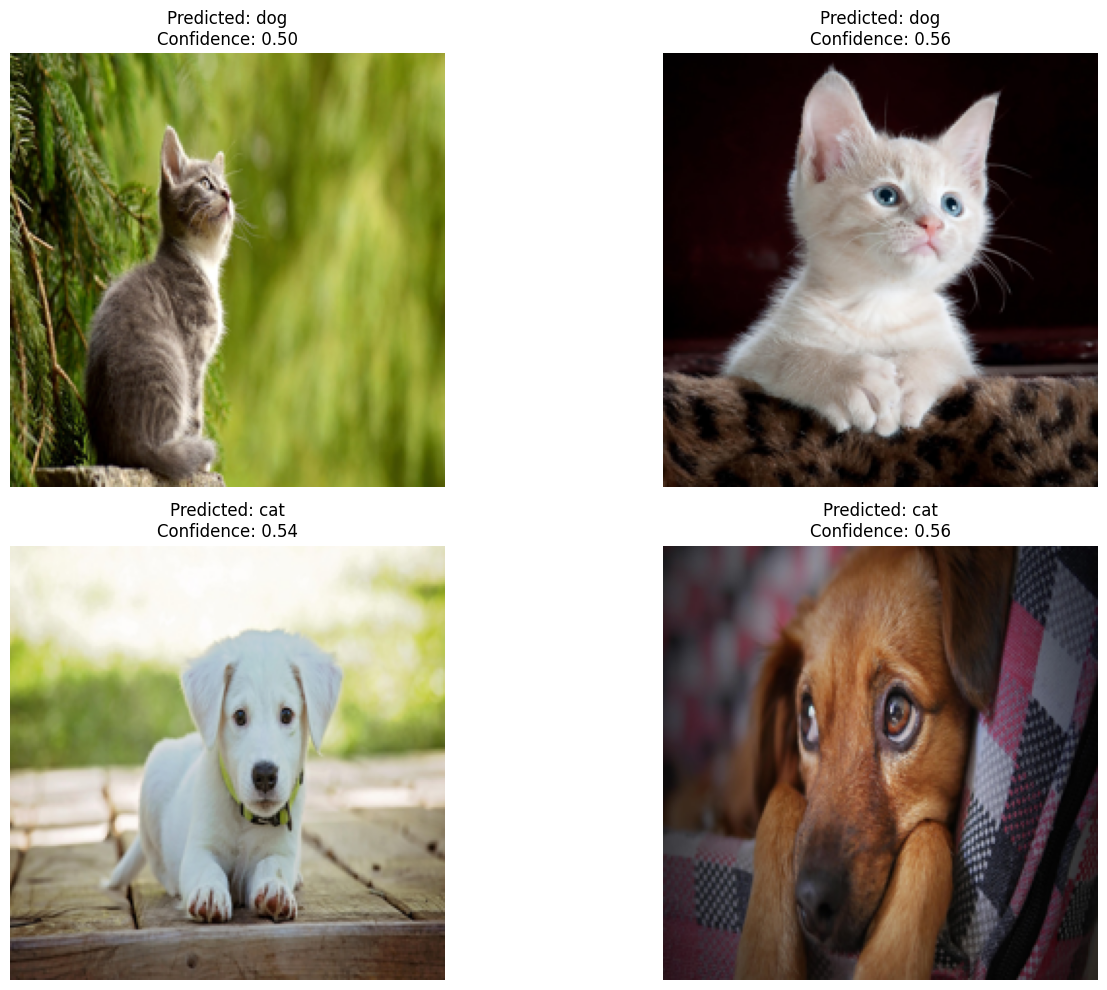

In [26]:
# Test with the best model
# Determine the best model
accuracies = {
    'EfficientNetB0': effnet_test_acc,
    'ResNet50': resnet_test_acc,
    'VGG16': vgg_test_acc
}

best_model_name = max(accuracies, key=accuracies.get)
best_model = {
    'EfficientNetB0': effnet_model,
    'ResNet50': resnet_model,
    'VGG16': vgg_model
}[best_model_name]

print(f"\nBest model: {best_model_name} with test accuracy: {accuracies[best_model_name]:.4f}")

# Test with downloaded images
print("\nTesting with downloaded images...")
test_with_downloaded_images(best_model, test_generator.class_indices)

## 6. Save the Best Model

In [27]:
# Save the best model
best_model.save(os.path.join(MODEL_SAVE_DIR, 'best_model.h5'))
print(f"Best model saved to {os.path.join(MODEL_SAVE_DIR, 'best_model.h5')}")
print("You can now load this model using: model = tf.keras.models.load_model('saved_models/best_model.h5')")

Best model saved to ./saved_models\best_model.h5
You can now load this model using: model = tf.keras.models.load_model('saved_models/best_model.h5')


## 7. Model Comparison and Conclusions

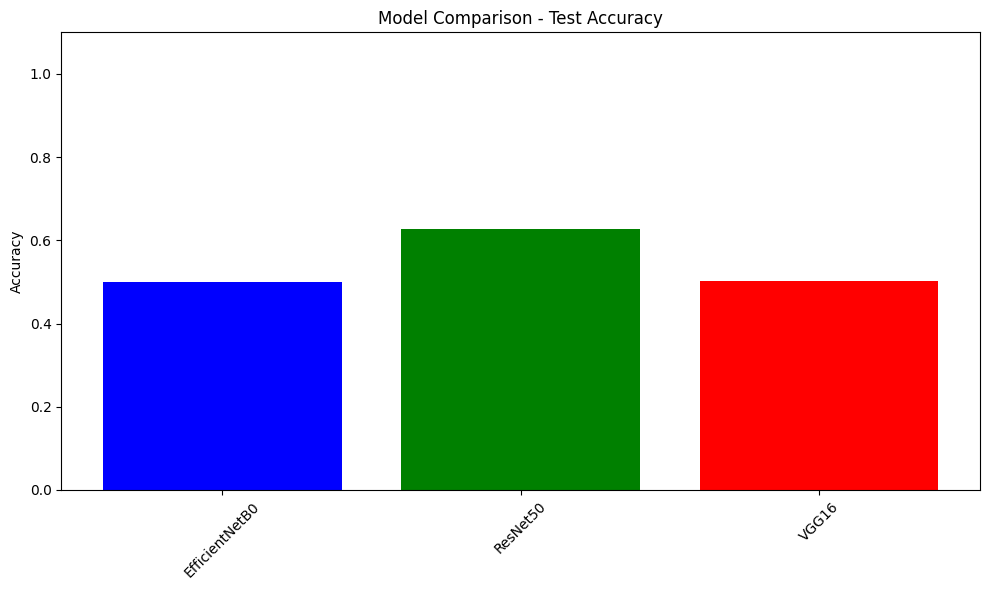

In [28]:
# Compare model performances
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red'])
plt.title('Model Comparison - Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()